
<h2 align='center'><a>1.Understanding the business problem</h2>

#### The objective is predicting store sales using historical markdown data

<h2 align='center'><a>2.Exploratory Data Analysis(EDA)</h2>

#### <a>Importing the necessary library.

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
sns.set()

import pandas_profiling 
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()

Saving features.csv to features.csv
Saving sampleSubmission.csv to sampleSubmission.csv
Saving stores.csv to stores.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


#### <a>Import the data

In [0]:
import io
train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
feature = pd.read_csv(io.BytesIO(uploaded['features.csv']))
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
stores = pd.read_csv(io.BytesIO(uploaded['stores.csv']))
sampleSubmission =pd.read_csv(io.BytesIO(uploaded['sampleSubmission.csv']))

In [0]:
train = train.copy()
feature = feature.copy()
test = test.copy()
stores =stores.copy()
sampleSubmission = sampleSubmission.copy() 

#### Merging the DataSet 
##### -(train+Store+Feature) &  -(test+Store+Feature)

In [0]:
train_ts = pd.merge(train,stores)  ##Merging the Dataset (train+Store+Feature)
train = pd.merge(train_ts,feature)

#############

test_ts = pd.merge(test,stores)  ##Merging the Dataset (test+Store+Feature)
test= pd.merge(test_ts,feature)

In [6]:
train.head(4) 

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [7]:
test.head(4)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
2,1,3,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
3,1,4,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


#### <a>Making friendship with data after importing.

In [8]:
print(train.info()) ### Info of dataset-train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
None


In [9]:
print(test.info()) ### Info of dataset-test

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Store           115064 non-null int64
Dept            115064 non-null int64
Date            115064 non-null object
IsHoliday       115064 non-null bool
Type            115064 non-null object
Size            115064 non-null int64
Temperature     115064 non-null float64
Fuel_Price      115064 non-null float64
MarkDown1       114915 non-null float64
MarkDown2       86437 non-null float64
MarkDown3       105235 non-null float64
MarkDown4       102176 non-null float64
MarkDown5       115064 non-null float64
CPI             76902 non-null float64
Unemployment    76902 non-null float64
dtypes: bool(1), float64(9), int64(3), object(2)
memory usage: 13.3+ MB
None


In [10]:
print(test.shape) ##Shape of test dataset

(115064, 15)


In [11]:
print(train.shape) ##Shape of train dataset

(421570, 16)


In [12]:
test_missing=test.isnull().sum()[test.isnull().sum()>0].reset_index() ## Missing value within the datasheet.
test_missing 

,index,0
0,MarkDown1,149
1,MarkDown2,28627
2,MarkDown3,9829
3,MarkDown4,12888
4,CPI,38162
5,Unemployment,38162


In [13]:
train_missing=train.isnull().sum()[train.isnull().sum()>0].reset_index()  ## Missing value within the datasheet.
train_missing 

,index,0
0,MarkDown1,270889
1,MarkDown2,310322
2,MarkDown3,284479
3,MarkDown4,286603
4,MarkDown5,270138


In [0]:
## The missing value within the above columns is mentioned-

#### <a>Creating Data audit Report

#### create UDFs

In [0]:
# Use a general function that returns multiple values-

# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                        x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [0]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [0]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

#### <a>Data Inspection

#### Training data-

In [0]:
#Rearrange the columns-
train=train[['Date','IsHoliday','Store','Dept','Type','Size','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3',
      'MarkDown4','MarkDown5','CPI','Unemployment','Weekly_Sales']]

In [19]:
train.head(4)

,Date,IsHoliday,Store,Dept,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
0,2010-02-05,False,1,1,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,24924.50
1,2010-02-05,False,1,2,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,50605.27
2,2010-02-05,False,1,3,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,13740.12
3,2010-02-05,False,1,4,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,39954.04


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Date            421570 non-null object
IsHoliday       421570 non-null bool
Store           421570 non-null int64
Dept            421570 non-null int64
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
Weekly_Sales    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [0]:
## Converting True & False in-Isholdays columns int i.e 1 and 0
train['IsHoliday']=train['IsHoliday'].astype('int64')

In [0]:
### Changed the datetype to Date-
train['Date'] = pd.to_datetime(train['Date'])

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Date            421570 non-null datetime64[ns]
IsHoliday       421570 non-null int64
Store           421570 non-null int64
Dept            421570 non-null int64
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
Weekly_Sales    421570 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(4), object(1)
memory usage: 54.7+ MB


In [24]:
train.head()

,Date,IsHoliday,Store,Dept,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
0,2010-02-05,0,1,1,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,24924.50
1,2010-02-05,0,1,2,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,50605.27
2,2010-02-05,0,1,3,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,13740.12
3,2010-02-05,0,1,4,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,39954.04
4,2010-02-05,0,1,5,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,32229.38


In [0]:
# seperate categorical and continuous variables
train_conti_vars = train.loc[:, (train.dtypes == 'float64') | (train.dtypes == 'int64')]
train_cat_vars = train.loc[:, (train.dtypes == 'object')]
train_date_vars = train.loc[:, (train.dtypes == 'datetime64[ns]')]


In [26]:
#checking P1 & Min(Outliers),P99 & Max(Outliers),Mean Median,NMISS(for missing values).

train_conti_vars.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
IsHoliday,421570.0,0.0,2.966100e+04,0.07,0.00,0.26,7.000000e-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
Store,421570.0,0.0,9.359084e+06,22.20,22.00,12.79,1.634600e+02,1.00,1.00,3.00,5.00,11.00,22.00,33.00,40.00,43.00,45.00,45.00
Dept,421570.0,0.0,1.865882e+07,44.26,37.00,30.49,9.297700e+02,1.00,1.00,4.00,7.00,18.00,37.00,74.00,92.00,95.00,98.00,99.00
Size,421570.0,0.0,5.764039e+10,136727.92,140167.00,60980.58,3.718632e+09,34875.00,34875.00,39690.00,39910.00,93638.00,140167.00,202505.00,204184.00,206302.00,219622.00,219622.00
Temperature,421570.0,0.0,2.533217e+07,60.09,62.09,18.45,3.403300e+02,-2.06,18.30,27.31,33.98,46.68,62.09,74.28,83.58,87.27,92.81,100.14
Fuel_Price,421570.0,0.0,1.416908e+06,3.36,3.45,0.46,2.100000e-01,2.47,2.56,2.65,2.72,2.93,3.45,3.74,3.92,4.03,4.20,4.47
MarkDown1,150681.0,270889.0,1.091898e+09,7246.42,5347.45,8291.22,6.874435e+07,0.27,17.76,149.19,375.20,2240.27,5347.45,9210.90,15282.47,21801.35,41524.03,88646.76
MarkDown2,111248.0,310322.0,3.709708e+08,3334.63,192.00,9475.36,8.978240e+07,-265.76,-0.99,1.95,6.98,41.60,192.00,1926.94,8549.74,16497.47,50366.60,104519.54
MarkDown3,137091.0,284479.0,1.973317e+08,1439.42,24.60,9623.08,9.260364e+07,-29.10,0.06,0.65,1.65,5.08,24.60,103.99,400.09,1059.90,63143.29,141630.61
MarkDown4,134967.0,286603.0,4.566161e+08,3383.17,1481.31,6292.38,3.959410e+07,0.22,3.97,28.76,108.71,504.22,1481.31,3595.04,7871.42,12645.96,35785.26,67474.85


In [27]:
#checking Mode,Freq,NMISS,Percent,Count.

train_cat_vars.apply(categorical_var_summary).T.round(2)

,N,NMISS,MODE,FREQ,PERCENT
Type,421570,0,A,215478,51.11


#### Testing  data-

In [0]:
#Rearrange the columns-
test=test[['Date', 'IsHoliday','Store', 'Dept', 'Type', 'Size', 'Temperature','Fuel_Price', 'MarkDown1', 'MarkDown2', 
           'MarkDown3', 'MarkDown4','MarkDown5', 'CPI', 'Unemployment']]

In [0]:
## Converting True & False in-Isholdays columns int i.e 1 and 0
test['IsHoliday']=test['IsHoliday'].astype('int64')

In [0]:
### Changed the datetype to Date-
test['Date'] = pd.to_datetime(test['Date'])

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Date            115064 non-null datetime64[ns]
IsHoliday       115064 non-null int64
Store           115064 non-null int64
Dept            115064 non-null int64
Type            115064 non-null object
Size            115064 non-null int64
Temperature     115064 non-null float64
Fuel_Price      115064 non-null float64
MarkDown1       114915 non-null float64
MarkDown2       86437 non-null float64
MarkDown3       105235 non-null float64
MarkDown4       102176 non-null float64
MarkDown5       115064 non-null float64
CPI             76902 non-null float64
Unemployment    76902 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(4), object(1)
memory usage: 14.0+ MB


In [32]:
test.head()

,Date,IsHoliday,Store,Dept,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,2012-11-02,0,1,1,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,2012-11-02,0,1,2,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
2,2012-11-02,0,1,3,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
3,2012-11-02,0,1,4,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
4,2012-11-02,0,1,5,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [0]:
# seperate categorical and continuous variables
test_conti_vars = test.loc[:, (test.dtypes == 'float64') | (test.dtypes == 'int64')]
test_cat_vars = test.loc[:, (test.dtypes == 'object')]
test_date_vars = test.loc[:, (test.dtypes == 'datetime64[ns]')]


In [34]:
#checking P1 & Min(Outliers),P99 & Max(Outliers),Mean Median,NMISS(for missing values).

test_conti_vars.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
IsHoliday,115064.0,0.0,8.928000e+03,0.08,0.00,0.27,7.000000e-02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
Store,115064.0,0.0,2.558817e+06,22.24,22.00,12.81,1.640900e+02,1.00,1.00,3.00,5.00,11.00,22.00,33.00,40.00,43.00,45.00,45.00
Dept,115064.0,0.0,5.101883e+06,44.34,37.00,30.66,9.398200e+02,1.00,1.00,4.00,7.00,18.00,37.00,74.00,92.00,95.00,98.00,99.00
Size,115064.0,0.0,1.570597e+10,136497.69,140167.00,61106.93,3.734056e+09,34875.00,34875.00,39690.00,39910.00,93638.00,140167.00,202505.00,204184.00,206302.00,219622.00,219622.00
Temperature,115064.0,0.0,6.206760e+06,53.94,54.47,18.72,3.505900e+02,-7.29,11.44,23.98,29.97,39.82,54.47,67.35,79.48,83.82,92.14,101.95
Fuel_Price,115064.0,0.0,4.121070e+05,3.58,3.61,0.24,6.000000e-02,2.87,2.96,3.16,3.23,3.43,3.61,3.77,3.87,3.95,4.08,4.12
MarkDown1,114915.0,149.0,8.836063e+08,7689.22,4842.29,10698.76,1.144635e+08,-2781.45,20.84,189.49,457.66,1966.46,4842.29,9439.14,15325.04,23140.88,65757.57,103184.98
MarkDown2,86437.0,28627.0,3.227602e+08,3734.05,742.59,8323.50,6.928057e+07,-35.74,0.02,6.14,25.77,180.35,742.59,2735.67,9277.29,22671.67,42920.21,71074.17
MarkDown3,105235.0,9829.0,2.528890e+08,2403.09,78.26,13767.94,1.895562e+08,-179.26,0.15,1.18,3.10,15.10,78.26,272.58,698.93,2361.57,86476.66,149483.31
MarkDown4,102176.0,12888.0,3.429250e+08,3356.22,840.94,7570.50,5.731249e+07,0.22,2.61,16.96,37.36,155.46,840.94,3096.92,7674.41,14191.01,44739.28,65344.64


In [35]:
#checking Mode,Freq,NMISS,Percent,Count.

test_cat_vars.apply(categorical_var_summary).T.round(2)

,N,NMISS,MODE,FREQ,PERCENT
Type,115064,0,A,58713,51.03


#### <a>Profiling report-

In [0]:
#pandas_profiling.ProfileReport(train)

In [0]:
#pandas_profiling.ProfileReport(test)

#### <a>Correlation

In [38]:
train_corr=pd.DataFrame(train.corr())
train_corr

,IsHoliday,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
IsHoliday,1.000000,-0.000548,0.000916,0.000593,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460,0.012774
Store,-0.000548,1.000000,0.024004,-0.182881,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552,-0.085195
Dept,0.000916,0.024004,1.000000,-0.002966,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837,0.148032
Size,0.000593,-0.182881,-0.002966,1.000000,-0.058313,0.003361,0.345673,0.108827,0.048913,0.168196,0.304575,-0.003314,-0.068238,0.243828
Temperature,-0.155949,-0.050097,0.004437,-0.058313,1.000000,0.143859,-0.040594,-0.323927,-0.096880,-0.063947,-0.017544,0.182112,0.096730,-0.002312
Fuel_Price,-0.078281,0.065290,0.003572,0.003361,0.143859,1.000000,0.061371,-0.220895,-0.102092,-0.044986,-0.128065,-0.164210,-0.033853,-0.000120
MarkDown1,-0.035586,-0.119588,-0.002426,0.345673,-0.040594,0.061371,1.000000,0.024486,-0.108115,0.819238,0.160257,-0.055558,0.050285,0.085251
MarkDown2,0.334818,-0.035173,0.000290,0.108827,-0.323927,-0.220895,0.024486,1.000000,-0.050108,-0.007768,-0.007440,-0.039534,0.020940,0.024130
MarkDown3,0.427960,-0.031556,0.001784,0.048913,-0.096880,-0.102092,-0.108115,-0.050108,1.000000,-0.071095,-0.026467,-0.023590,0.012818,0.060385
MarkDown4,-0.000562,-0.009941,0.004257,0.168196,-0.063947,-0.044986,0.819238,-0.007768,-0.071095,1.000000,0.107792,-0.049628,0.024963,0.045414


In [39]:
test_corr=pd.DataFrame(test.corr())
test_corr

,IsHoliday,Store,Dept,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
IsHoliday,1.000000,-0.001166,0.001249,-0.000443,-0.187428,-0.126443,0.355257,0.265402,0.496062,0.289700,-0.019386,-0.001475,0.010288
Store,-0.001166,1.000000,0.019627,-0.186845,-0.043495,0.153425,-0.091707,-0.041370,-0.025177,0.010331,0.010419,-0.214872,0.250321
Dept,0.001249,0.019627,1.000000,0.001502,0.003970,0.000554,-0.002353,0.001292,0.000247,0.002510,0.000776,-0.006336,0.004087
Size,-0.000443,-0.186845,0.001502,1.000000,-0.061256,0.055088,0.309614,0.157526,0.050088,0.155448,0.103681,-0.002916,-0.001988
Temperature,-0.187428,-0.043495,0.003970,-0.061256,1.000000,0.073938,-0.168899,-0.324280,-0.049771,-0.059583,0.003937,0.280861,0.022136
Fuel_Price,-0.126443,0.153425,0.000554,0.055088,0.073938,1.000000,0.083320,-0.161963,-0.005827,0.034199,0.012722,-0.465721,0.417126
MarkDown1,0.355257,-0.091707,-0.002353,0.309614,-0.168899,0.083320,1.000000,0.001777,-0.090085,0.804449,0.061714,-0.028729,0.019241
MarkDown2,0.265402,-0.041370,0.001292,0.157526,-0.324280,-0.161963,0.001777,1.000000,-0.063757,-0.101784,-0.014159,-0.059350,-0.000547
MarkDown3,0.496062,-0.025177,0.000247,0.050088,-0.049771,-0.005827,-0.090085,-0.063757,1.000000,-0.059576,-0.015305,-0.022021,0.006298
MarkDown4,0.289700,0.010331,0.002510,0.155448,-0.059583,0.034199,0.804449,-0.101784,-0.059576,1.000000,0.024163,-0.056629,0.021993


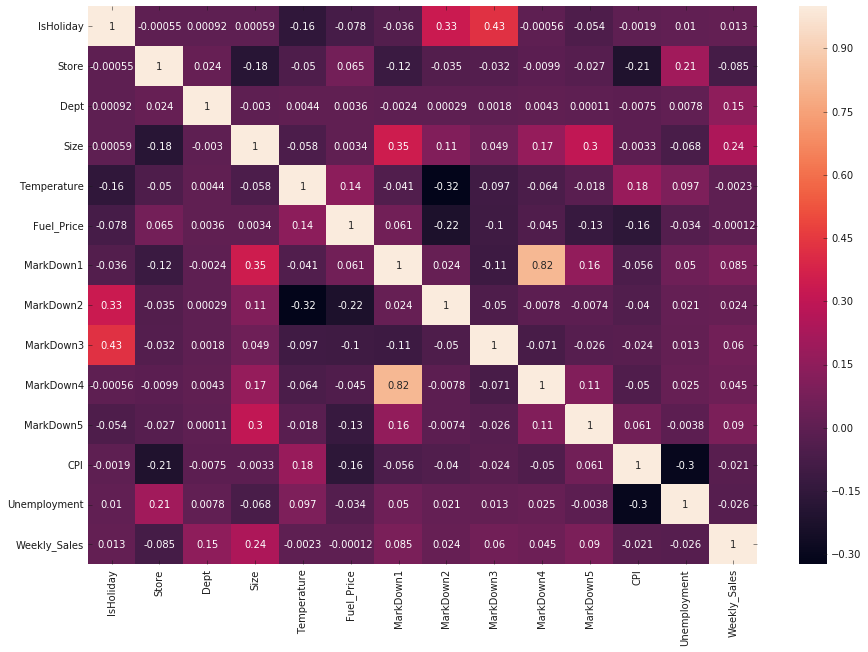

In [40]:
# visualize correlation matrix in Seaborn using a heatmap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(train.corr(),annot=True,ax=ax)

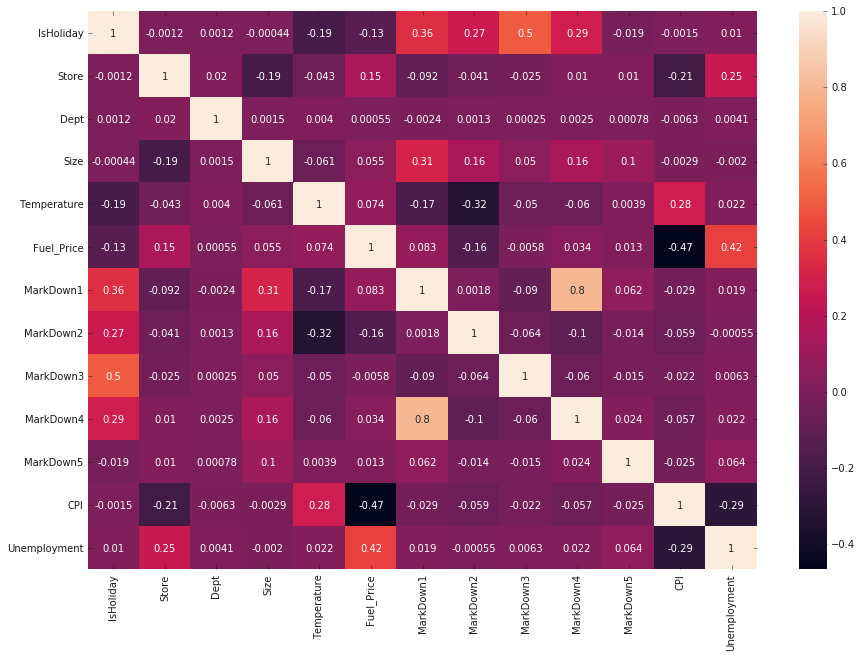

In [41]:
# visualize correlation matrix in Seaborn using a heatmap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(test.corr(),annot=True,ax=ax)

### <a>Visualisation- of dataset-

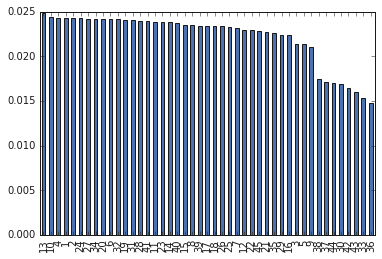

In [42]:
### Visualisation of train data on the bases of columns store -
train['Store'].value_counts(normalize=True).plot(kind = 'bar',fig=(15,10))

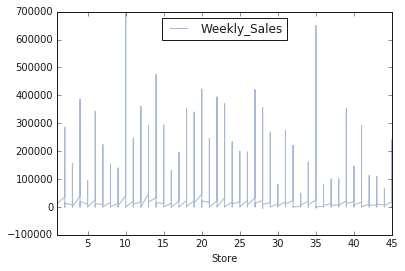

In [43]:
### Store Size vs Sales

train.plot(kind='line', y='Weekly_Sales', x='Store', alpha=0.5)

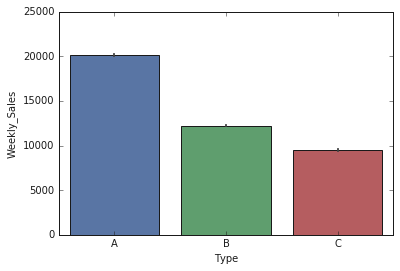

In [44]:
## Sales vs Type 

#tips = sns.load_dataset('train')
sns.barplot(y=train["Weekly_Sales"],x=train["Type"])

In [0]:
###Sales vs Deptartment

# train.plot(kind='line', x='Dept', y='Weekly_Sales', alpha=1.5)

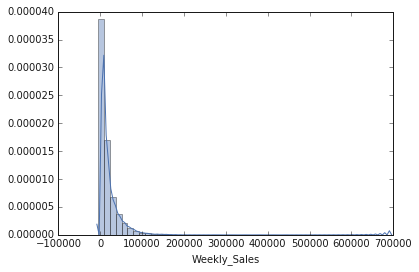

In [48]:
## 'Y' should be normal.
sns.distplot(train.Weekly_Sales)

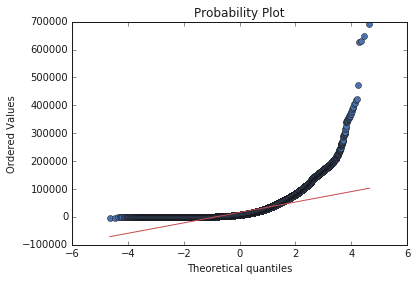

In [49]:
from scipy import stats
import pylab

stats.probplot(train.Weekly_Sales, dist="norm", plot=pylab )
pylab.show()

<h1 align='center'> <a>3.Treatment of Data</h1>

In [0]:
###Outlier Treatment
train_conti_vars= train_conti_vars.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.dropna().quantile(0.99)))

test_conti_vars= test_conti_vars.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.dropna().quantile(0.99)))

In [51]:
train_conti_vars.apply(continuous_var_summary).T.round()

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
IsHoliday,421570.0,0.0,2.966100e+04,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Store,421570.0,0.0,9.359084e+06,22.0,22.0,13.0,1.630000e+02,1.0,1.0,3.0,5.0,11.0,22.0,33.0,40.0,43.0,45.0,45.0
Dept,421570.0,0.0,1.865796e+07,44.0,37.0,30.0,9.300000e+02,1.0,1.0,4.0,7.0,18.0,37.0,74.0,92.0,95.0,98.0,98.0
Size,421570.0,0.0,5.764039e+10,136728.0,140167.0,60981.0,3.718632e+09,34875.0,34875.0,39690.0,39910.0,93638.0,140167.0,202505.0,204184.0,206302.0,219622.0,219622.0
Temperature,421570.0,0.0,2.533977e+07,60.0,62.0,18.0,3.350000e+02,18.0,18.0,27.0,34.0,47.0,62.0,74.0,84.0,87.0,93.0,93.0
Fuel_Price,421570.0,0.0,1.416587e+06,3.0,3.0,0.0,0.000000e+00,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0
MarkDown1,150681.0,270889.0,1.069989e+09,7101.0,5347.0,7421.0,5.507651e+07,18.0,18.0,149.0,375.0,2240.0,5347.0,9211.0,15282.0,21801.0,41524.0,41524.0
MarkDown2,111248.0,310322.0,3.498977e+08,3145.0,192.0,8060.0,6.495681e+07,-1.0,-1.0,2.0,7.0,42.0,192.0,1927.0,8550.0,16497.0,50367.0,50367.0
MarkDown3,137091.0,284479.0,1.690173e+08,1233.0,25.0,7697.0,5.924192e+07,0.0,0.0,1.0,2.0,5.0,25.0,104.0,400.0,1060.0,63143.0,63143.0
MarkDown4,134967.0,286603.0,4.408980e+08,3267.0,1481.0,5487.0,3.010277e+07,4.0,4.0,29.0,109.0,504.0,1481.0,3595.0,7871.0,12646.0,35785.0,35785.0


In [52]:
test_conti_vars.apply(continuous_var_summary).T.round()

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
IsHoliday,115064.0,0.0,8.928000e+03,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
Store,115064.0,0.0,2.558817e+06,22.0,22.0,13.0,1.640000e+02,1.0,1.0,3.0,5.0,11.0,22.0,33.0,40.0,43.0,45.0,45.0
Dept,115064.0,0.0,5.101270e+06,44.0,37.0,31.0,9.390000e+02,1.0,1.0,4.0,7.0,18.0,37.0,74.0,92.0,95.0,98.0,98.0
Size,115064.0,0.0,1.570597e+10,136498.0,140167.0,61107.0,3.734056e+09,34875.0,34875.0,39690.0,39910.0,93638.0,140167.0,202505.0,204184.0,206302.0,219622.0,219622.0
Temperature,115064.0,0.0,6.210784e+06,54.0,54.0,18.0,3.420000e+02,11.0,11.0,24.0,30.0,40.0,54.0,67.0,79.0,84.0,92.0,92.0
Fuel_Price,115064.0,0.0,4.121380e+05,4.0,4.0,0.0,0.000000e+00,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0
MarkDown1,114915.0,149.0,8.708615e+08,7578.0,4842.0,9947.0,9.894828e+07,21.0,21.0,189.0,458.0,1966.0,4842.0,9439.0,15325.0,23141.0,65758.0,65758.0
MarkDown2,86437.0,28627.0,3.150426e+08,3645.0,743.0,7806.0,6.093963e+07,0.0,0.0,6.0,26.0,180.0,743.0,2736.0,9277.0,22672.0,42920.0,42920.0
MarkDown3,105235.0,9829.0,2.260320e+08,2148.0,78.0,11663.0,1.360269e+08,0.0,0.0,1.0,3.0,15.0,78.0,273.0,699.0,2362.0,86477.0,86477.0
MarkDown4,102176.0,12888.0,3.338188e+08,3267.0,841.0,6975.0,4.865428e+07,3.0,3.0,17.0,37.0,155.0,841.0,3097.0,7674.0,14191.0,44739.0,44739.0


#### <a>MISSING IMPUTATION(Filling the missing values with appropriate value)

In [0]:
#### Missing Imputing it with its mean-i.e-CPI & Unemployment.
test_conti_vars=test_conti_vars.copy()
test_conti_vars[['CPI','Unemployment']] = test_conti_vars[['CPI','Unemployment']].apply(missing_imputation)

In [54]:
test_conti_vars.isna().sum()

IsHoliday           0
Store               0
Dept                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI                 0
Unemployment        0
dtype: int64

In [0]:
#### Missing Imputing the Markdown with zero.
test_conti_vars = test_conti_vars.fillna(0)
train_conti_vars  =train_conti_vars.fillna(0)

In [56]:
test_conti_vars.isna().sum()

IsHoliday       0
Store           0
Dept            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

In [57]:
train_conti_vars.isna().sum()

IsHoliday       0
Store           0
Dept            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Weekly_Sales    0
dtype: int64

In [0]:
from datetime import datetime  
from datetime import timedelta


train_date_vars=train_date_vars.copy()
test_date_vars=test_date_vars.copy()

##Finding dates in no. of weeks,months,years & days.

train_date_vars['Date_Week']=train_date_vars.Date.dt.week
train_date_vars['Date_Month'] =train_date_vars['Date'].dt.month 
train_date_vars['Date_Year'] =train_date_vars['Date'].dt.year
train_date_vars['Date_Day'] =train_date_vars['Date'].dt.day 

test_date_vars['Date_Week']=test_date_vars.Date.dt.week
test_date_vars['Date_Month'] =test_date_vars['Date'].dt.month 
test_date_vars['Date_Year'] =test_date_vars['Date'].dt.year
test_date_vars['Date_Day'] =test_date_vars['Date'].dt.day

# Making New Holiday-

train_date_vars['Super_Bowl'] = np.where((train_date_vars['Date'] == datetime(2010, 2, 12)) | (train_date_vars['Date'] == datetime(2011, 2, 11)) | (train_date_vars['Date'] == datetime(2012, 2, 10)) | (train_date_vars['Date'] == datetime(2013, 2, 8)), 1, 0)
train_date_vars['Labour_Day'] = np.where((train_date_vars['Date'] == datetime(2010, 9, 10)) | (train_date_vars['Date'] == datetime(2011, 9, 9)) | (train_date_vars['Date'] == datetime(2012, 9, 7)) | (train_date_vars['Date'] == datetime(2013, 9, 6)), 1, 0)
train_date_vars['Thanks_giving'] = np.where((train_date_vars['Date'] == datetime(2010, 11, 26)) | (train_date_vars['Date'] == datetime(2011, 11, 25)) | (train_date_vars['Date'] == datetime(2012, 11, 23)) | (train_date_vars['Date'] == datetime(2013, 11, 29)), 1, 0)
train_date_vars['Christmas'] = np.where((train_date_vars['Date'] == datetime(2010, 12, 31)) | (train_date_vars['Date'] == datetime(2011, 12, 30)) | (train_date_vars['Date'] == datetime(2012, 12, 28)) | (train_date_vars['Date'] == datetime(2013, 12, 27)), 1, 0)

###########################

test_date_vars['Super_Bowl'] = np.where((test_date_vars['Date'] == datetime(2010, 2, 12)) | (test_date_vars['Date'] == datetime(2011, 2, 11)) | (test_date_vars['Date'] == datetime(2012, 2, 10)) | (test_date_vars['Date'] == datetime(2013, 2, 8)), 1, 0)
test_date_vars['Labour_Day'] = np.where((test_date_vars['Date'] == datetime(2010, 9, 10)) | (test_date_vars['Date'] == datetime(2011, 9, 9)) | (test_date_vars['Date'] == datetime(2012, 9, 7)) | (test_date_vars['Date'] == datetime(2013, 9, 6)), 1, 0)
test_date_vars['Thanks_giving'] = np.where((test_date_vars['Date'] == datetime(2010, 11, 26)) | (test_date_vars['Date'] == datetime(2011, 11, 25)) | (test_date_vars['Date'] == datetime(2012, 11, 23)) | (test_date_vars['Date'] == datetime(2013, 11, 29)), 1, 0)
test_date_vars['Christmas'] = np.where((test_date_vars['Date'] == datetime(2010, 12, 31)) | (test_date_vars['Date'] == datetime(2011, 12, 30)) | (test_date_vars['Date'] == datetime(2012, 12, 28)) | (test_date_vars['Date'] == datetime(2013, 12, 27)), 1, 0)



In [0]:
# Getting one final consolidated table to build our model on

train_final = pd.concat([train_date_vars, train_cat_vars,train_conti_vars], axis = 1)

test_final = pd.concat([test_date_vars, test_cat_vars,test_conti_vars], axis = 1)

In [0]:
## Altering the isHoliday value depending on these new holidays...
train_final['IsHoliday']=train_final['IsHoliday']|train_final['Super_Bowl']|train_final['Labour_Day']|train_final['Thanks_giving']|train_final['Christmas']

test_final['IsHoliday']=test_final['IsHoliday']|test_final['Super_Bowl']|test_final['Labour_Day']|test_final['Thanks_giving']|test_final['Christmas']

# Since we have Imputed IsHoliday according to Extra holidays-

## These extra holiday variable has redundant-
# Droping the Extra holiday variables because its redundant-
dp=['Super_Bowl','Labour_Day','Thanks_giving','Christmas']
train_final.drop(dp,axis=1,inplace=True)
test_final.drop(dp,axis=1,inplace=True)

In [0]:
train_final[[ 'Temperature', 'Fuel_Price','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Weekly_Sales']]=train_final[['Temperature', 'Fuel_Price','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Weekly_Sales']].astype('int64')

test_final[[ 'Temperature', 'Fuel_Price','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment']]=test_final[[ 'Temperature', 'Fuel_Price','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment']].astype('int64')

In [62]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
Date            421570 non-null datetime64[ns]
Date_Week       421570 non-null int64
Date_Month      421570 non-null int64
Date_Year       421570 non-null int64
Date_Day        421570 non-null int64
Type            421570 non-null object
IsHoliday       421570 non-null int64
Store           421570 non-null int64
Dept            421570 non-null int64
Size            421570 non-null int64
Temperature     421570 non-null int64
Fuel_Price      421570 non-null int64
MarkDown1       421570 non-null int64
MarkDown2       421570 non-null int64
MarkDown3       421570 non-null int64
MarkDown4       421570 non-null int64
MarkDown5       421570 non-null int64
CPI             421570 non-null int64
Unemployment    421570 non-null int64
Weekly_Sales    421570 non-null int64
dtypes: datetime64[ns](1), int64(18), object(1)
memory usage: 67.5+ MB


In [63]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 19 columns):
Date            115064 non-null datetime64[ns]
Date_Week       115064 non-null int64
Date_Month      115064 non-null int64
Date_Year       115064 non-null int64
Date_Day        115064 non-null int64
Type            115064 non-null object
IsHoliday       115064 non-null int64
Store           115064 non-null int64
Dept            115064 non-null int64
Size            115064 non-null int64
Temperature     115064 non-null int64
Fuel_Price      115064 non-null int64
MarkDown1       115064 non-null int64
MarkDown2       115064 non-null int64
MarkDown3       115064 non-null int64
MarkDown4       115064 non-null int64
MarkDown5       115064 non-null int64
CPI             115064 non-null int64
Unemployment    115064 non-null int64
dtypes: datetime64[ns](1), int64(17), object(1)
memory usage: 17.6+ MB


#### Dummy Variables-
    I have tried alot but error is showing after concatenating the dummy variable,
    The memory based error hindered my further approach as well as my system is 32 bit operating.
    Hence I have changed the process and without making dummies proceeding further.Please accept it. 


In [0]:
dummy_1 = ['Type','Store', 'Dept']
dummy_2 = ['Type','Store', 'Dept']
dummy_11 = train_final[dummy_1].astype('category')
dummy_22 = test_final[dummy_2].astype('category')


df=pd.get_dummies(dummy_11,drop_first=True)  
df_2=pd.get_dummies(dummy_22,drop_first=True)  
train_final= train_final.drop(columns = ['Type','Store', 'Dept'])
test_final= test_final.drop(columns = ['Type','Store', 'Dept'])

# Getting one final consolidated table to build our model on
train_final = pd.concat([train_final,df], axis = 1)
test_final = pd.concat([test_final,df_2], axis = 1)

In [0]:
#Converting Categorical Variable 'Type' into Numerical Variable¶
# For A=1 , B=2, C=3

In [0]:
# train_final['Type'] = np.where((train_final['Type']=='A'),1,
#                         np.where((train_final['Type']=='B'),2,
#                             np.where((train_final['Type']=='C'),3,0))).astype('int64')
# test_final['Type'] = np.where((test_final['Type']=='A'),1,
#                         np.where((test_final['Type']=='B'),2,
#                             np.where((test_final['Type']=='C'),3,0))).astype('int64')

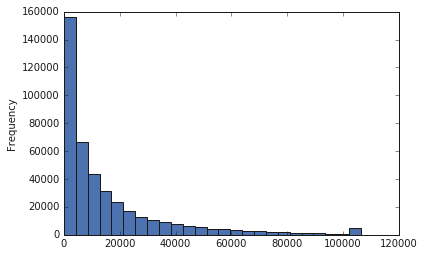

In [67]:
train_final.Weekly_Sales.plot.hist(bins=25)

In [0]:
# train_final.Type.value_counts()

In [0]:
# train_final.Type.value_counts()

In [71]:
train_final.IsHoliday.value_counts()

0    391909
1     29661
Name: IsHoliday, dtype: int64

In [72]:
train_final.IsHoliday.value_counts()

0    391909
1     29661
Name: IsHoliday, dtype: int64

In [73]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Columns: 142 entries, Date to Dept_98
dtypes: datetime64[ns](1), int64(16), uint8(125)
memory usage: 108.1 MB


In [74]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Columns: 141 entries, Date to Dept_98
dtypes: datetime64[ns](1), int64(15), uint8(125)
memory usage: 28.6 MB


In [75]:
test_final.IsHoliday.value_counts()

0    106136
1      8928
Name: IsHoliday, dtype: int64

### ASSUMPTIONS

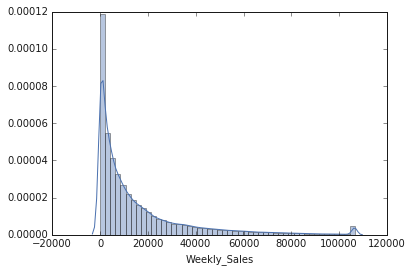

In [76]:
# #Y SHOULD BE NORMAL

sns.distplot(train_final.Weekly_Sales)
# # To check whether Y normal or not we can plot a distance plot which gives me a histogram with a line.

In [0]:
# # Here i can clearly see that my Y variable i.e. dependent variable is not normally distributed.
# # to make it normal i will take log of this

train_final['ln_Weekly_Sales'] = np.log(train_final.Weekly_Sales)

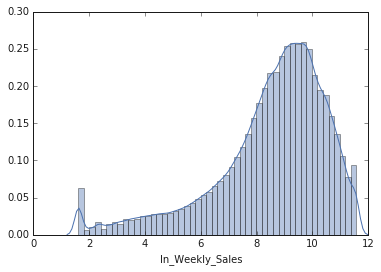

In [78]:
sns.distplot(train_final.ln_Weekly_Sales)

In [79]:
train_final.ln_Weekly_Sales.isna().sum()
# # There are no missing values in the y variable now

0

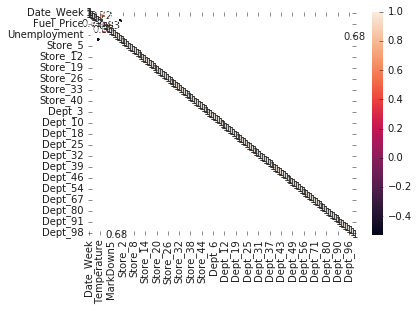

In [80]:
#train_final.corr()
sns.heatmap(train_final.corr()[abs(train_final.corr())>0.5],annot=True)

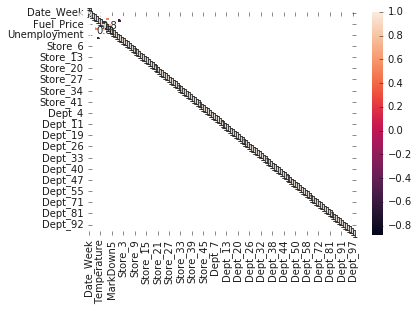

In [81]:
#test_final.corr()
sns.heatmap(test_final.corr()[abs(test_final.corr())>0.5],annot=True)

In [82]:
cor=train_final.corr()[abs(train_final.corr())>0.5].unstack().reset_index()
cor

,level_0,level_1,0
0,Date_Week,Date_Week,1.000000
1,Date_Week,Date_Month,0.995999
2,Date_Week,Date_Year,NaN
3,Date_Week,Date_Day,NaN
4,Date_Week,IsHoliday,NaN
...,...,...,...
20159,ln_Weekly_Sales,Dept_95,NaN
20160,ln_Weekly_Sales,Dept_96,NaN
20161,ln_Weekly_Sales,Dept_97,NaN
20162,ln_Weekly_Sales,Dept_98,NaN


In [83]:
cor_1=cor.loc[cor['level_0']!=cor['level_1']]
cor_1

,level_0,level_1,0
1,Date_Week,Date_Month,0.995999
2,Date_Week,Date_Year,NaN
3,Date_Week,Date_Day,NaN
4,Date_Week,IsHoliday,NaN
5,Date_Week,Size,NaN
...,...,...,...
20158,ln_Weekly_Sales,Dept_94,NaN
20159,ln_Weekly_Sales,Dept_95,NaN
20160,ln_Weekly_Sales,Dept_96,NaN
20161,ln_Weekly_Sales,Dept_97,NaN


In [84]:
cor_2=cor_1.loc[cor_1[0]>0]
cor_2

,level_0,level_1,0
1,Date_Week,Date_Month,0.995999
142,Date_Month,Date_Week,0.995999
291,Date_Year,Fuel_Price,0.722214
292,Date_Year,MarkDown1,0.530269
996,Fuel_Price,Date_Year,0.722214
1138,MarkDown1,Date_Year,0.530269
1147,MarkDown1,MarkDown4,0.826712
1148,MarkDown1,MarkDown5,0.534392
1570,MarkDown4,MarkDown1,0.826712
1712,MarkDown5,MarkDown1,0.534392


In [0]:
#### LINEAR REGRESSION MODEL

In [0]:
# import statsmodels.api as sm
# from sklearn import metrics
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVC, LinearSVC
# from sklearn.metrics import mean_squared_error as mse
# from sklearn.metrics import mean_absolute_error, mean_squared_error

In [87]:
print(train_final.columns.to_list())

['Date', 'Date_Week', 'Date_Month', 'Date_Year', 'Date_Day', 'IsHoliday', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Weekly_Sales', 'Type_B', 'Type_C', 'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45', 'Dept_2', 'Dept_3', 'Dept_4', 'Dept_5', 'Dept_6', 'Dept_7', 'Dept_8', 'Dept_9', 'Dept_10', 'Dept_11', 'Dept_12', 'Dept_13', 'Dept_14', 'Dept_16', 'Dept_17', 'Dept_18', 'Dept_19', 'Dept_20', 'Dept_21', 'Dept_22', 'Dept_23', 'Dept_24', 'Dept_25', 

In [0]:
'Type_C','Store_3','Store_5',

In [123]:
New_Select=['Date_Month', 'Date_Year', 'Size', 'Temperature', 'MarkDown1', 'MarkDown2', 
            'MarkDown3', 'MarkDown5', 'CPI', 'Type_B',
            'Store_2', 'Store_4',  'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Store_11',  'Store_13', 
            'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19', 'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24',
            'Store_25', 'Store_27', 'Store_28', 'Store_29',  'Store_31', 'Store_32', 'Store_33', 'Store_34', 'Store_35',
            'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45', 
            'Dept_2', 'Dept_3', 'Dept_4', 'Dept_5', 'Dept_6', 'Dept_7', 'Dept_8', 'Dept_9', 'Dept_10', 'Dept_11', 'Dept_12', 'Dept_13', 
            'Dept_14', 'Dept_16', 'Dept_17', 'Dept_18', 'Dept_19', 'Dept_20', 'Dept_21', 'Dept_22', 'Dept_23', 'Dept_24', 'Dept_25', 'Dept_26',
            'Dept_27', 'Dept_28', 'Dept_29', 'Dept_30', 'Dept_31', 'Dept_32', 'Dept_33', 'Dept_34', 'Dept_35', 'Dept_36', 'Dept_37', 'Dept_38', 
            'Dept_39', 'Dept_40', 'Dept_41', 'Dept_42', 'Dept_43', 'Dept_44', 'Dept_45', 'Dept_47', 'Dept_48', 'Dept_49', 'Dept_50',
            'Dept_51', 'Dept_52', 'Dept_54', 'Dept_55', 'Dept_56', 'Dept_58', 'Dept_59', 'Dept_60', 'Dept_65', 'Dept_67', 'Dept_71', 'Dept_72', 
            'Dept_74', 'Dept_77', 'Dept_78', 'Dept_79', 'Dept_80', 'Dept_81', 'Dept_82', 'Dept_83', 'Dept_85', 'Dept_87', 'Dept_90', 'Dept_91', 
            'Dept_92', 'Dept_93', 'Dept_94', 'Dept_95', 'Dept_96', 'Dept_97', 'Dept_98']
New_Select.append('ln_Weekly_Sales')

N_r=train_final[New_Select]

N_r.head()

,Date_Month,Date_Year,Size,Temperature,MarkDown1,MarkDown2,MarkDown3,MarkDown5,CPI,Type_B,Store_2,Store_4,Store_6,Store_7,Store_8,Store_9,Store_11,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_27,Store_28,Store_29,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,...,Dept_42,Dept_43,Dept_44,Dept_45,Dept_47,Dept_48,Dept_49,Dept_50,Dept_51,Dept_52,Dept_54,Dept_55,Dept_56,Dept_58,Dept_59,Dept_60,Dept_65,Dept_67,Dept_71,Dept_72,Dept_74,Dept_77,Dept_78,Dept_79,Dept_80,Dept_81,Dept_82,Dept_83,Dept_85,Dept_87,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,ln_Weekly_Sales
0,2,2010,151315,42,0,0,0,0,211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.123586
1,2,2010,151315,42,0,0,0,0,211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.831806
2,2,2010,151315,42,0,0,0,0,211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.528067
3,2,2010,151315,42,0,0,0,0,211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.595484
4,2,2010,151315,42,0,0,0,0,211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.380622


In [0]:
# # Splitting the dataset into training and testing dataset to build our model-

from sklearn.model_selection import train_test_split 

train, test = train_test_split(N_r, test_size = 0.25, random_state = 0)

In [125]:
cor_2

,level_0,level_1,0
1,Date_Week,Date_Month,0.995999
142,Date_Month,Date_Week,0.995999
291,Date_Year,Fuel_Price,0.722214
292,Date_Year,MarkDown1,0.530269
996,Fuel_Price,Date_Year,0.722214
1138,MarkDown1,Date_Year,0.530269
1147,MarkDown1,MarkDown4,0.826712
1148,MarkDown1,MarkDown5,0.534392
1570,MarkDown4,MarkDown1,0.826712
1712,MarkDown5,MarkDown1,0.534392


In [126]:
import statsmodels.formula.api as smf

stats="+".join(N_r.columns.difference(['ln_Weekly_Sales']))
'ln_Weekly_Sales ~' + stats

'ln_Weekly_Sales ~CPI+Date_Month+Date_Year+Dept_10+Dept_11+Dept_12+Dept_13+Dept_14+Dept_16+Dept_17+Dept_18+Dept_19+Dept_2+Dept_20+Dept_21+Dept_22+Dept_23+Dept_24+Dept_25+Dept_26+Dept_27+Dept_28+Dept_29+Dept_3+Dept_30+Dept_31+Dept_32+Dept_33+Dept_34+Dept_35+Dept_36+Dept_37+Dept_38+Dept_39+Dept_4+Dept_40+Dept_41+Dept_42+Dept_43+Dept_44+Dept_45+Dept_47+Dept_48+Dept_49+Dept_5+Dept_50+Dept_51+Dept_52+Dept_54+Dept_55+Dept_56+Dept_58+Dept_59+Dept_6+Dept_60+Dept_65+Dept_67+Dept_7+Dept_71+Dept_72+Dept_74+Dept_77+Dept_78+Dept_79+Dept_8+Dept_80+Dept_81+Dept_82+Dept_83+Dept_85+Dept_87+Dept_9+Dept_90+Dept_91+Dept_92+Dept_93+Dept_94+Dept_95+Dept_96+Dept_97+Dept_98+MarkDown1+MarkDown2+MarkDown3+MarkDown5+Size+Store_11+Store_13+Store_14+Store_15+Store_16+Store_17+Store_18+Store_19+Store_2+Store_20+Store_21+Store_22+Store_23+Store_24+Store_25+Store_27+Store_28+Store_29+Store_31+Store_32+Store_33+Store_34+Store_35+Store_36+Store_37+Store_38+Store_39+Store_4+Store_40+Store_41+Store_42+Store_43+Store_44+S

In [127]:
lm1 = smf.ols('''ln_Weekly_Sales ~CPI+Date_Month+Date_Year+Dept_10+Dept_11+Dept_12+Dept_13+Dept_14+Dept_16+Dept_17+Dept_18+Dept_19+Dept_2+Dept_20+Dept_21+Dept_22+Dept_23+Dept_24+Dept_25+Dept_26+Dept_27+Dept_28+Dept_29+Dept_3+Dept_30+Dept_31+Dept_32+Dept_33+Dept_34+Dept_35+Dept_36+Dept_37+Dept_38+Dept_39+Dept_4+Dept_40+Dept_41+Dept_42+Dept_43+Dept_44+Dept_45+Dept_47+Dept_48+Dept_49+Dept_5+Dept_50+Dept_51+Dept_52+Dept_54+Dept_55+Dept_56+Dept_58+Dept_59+Dept_6+Dept_60+Dept_65+Dept_67+Dept_7+Dept_71+Dept_72+Dept_74+Dept_77+Dept_78+Dept_79+Dept_8+Dept_80+Dept_81+Dept_82+Dept_83+Dept_85+Dept_87+Dept_9+Dept_90+Dept_91+Dept_92+Dept_93+Dept_94+Dept_95+Dept_96+Dept_97+Dept_98+MarkDown1+MarkDown2+MarkDown3+MarkDown5+Size+Store_11+Store_13+Store_14+Store_15+Store_16+Store_17+Store_18+Store_19+Store_2+Store_20+Store_21+Store_22+Store_23+Store_24+Store_25+Store_27+Store_28+Store_29+Store_31+Store_32+Store_33+Store_34+Store_35+Store_36+Store_37+Store_38+Store_39+Store_4+Store_40+Store_41+Store_42+Store_43+Store_44+Store_45+Store_6+Store_7+Store_8+Store_9+Temperature+Type_B''', train).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:        ln_Weekly_Sales   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     5244.
Date:                Fri, 13 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:40:58   Log-Likelihood:            -4.9726e+05
No. Observations:              316177   AIC:                         9.948e+05
Df Residuals:                  316050   BIC:                         9.961e+05
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     188.3705      7.000     26.912      

In [128]:
lm1.pvalues[(lm1.pvalues>0.05)].sort_values(ascending=False)

Series([], dtype: float64)

In [133]:
lm1 = smf.ols('''ln_Weekly_Sales ~CPI+Date_Month+Date_Year+Dept_10+Dept_11+Dept_12+Dept_13+Dept_14+Dept_16+Dept_17+Dept_18+Dept_19+Dept_2+Dept_20+Dept_21+Dept_22+Dept_23+Dept_24+Dept_25+Dept_26+Dept_27+Dept_28+Dept_29+Dept_3+Dept_30+Dept_31+Dept_32+Dept_33+Dept_34+Dept_35+Dept_36+Dept_37+Dept_38+Dept_39+Dept_4+Dept_40+Dept_41+Dept_42+Dept_43+Dept_44+Dept_45+Dept_47+Dept_48+Dept_49+Dept_5+Dept_50+Dept_51+Dept_52+Dept_54+Dept_55+Dept_56+Dept_58+Dept_59+Dept_6+Dept_60+Dept_65+Dept_67+Dept_7+Dept_71+Dept_72+Dept_74+Dept_77+Dept_78+Dept_79+Dept_8+Dept_80+Dept_81+Dept_82+Dept_83+Dept_85+Dept_87+Dept_9+Dept_90+Dept_91+Dept_92+Dept_93+Dept_94+Dept_95+Dept_96+Dept_97+Dept_98+MarkDown1+MarkDown2+MarkDown3+MarkDown5+Size+Store_11+Store_13+Store_14+Store_15+Store_16+Store_17+Store_18+Store_19+Store_2+Store_20+Store_21+Store_22+Store_23+Store_24+Store_25+Store_27+Store_28+Store_29+Store_31+Store_32+Store_33+Store_34+Store_35+Store_36+Store_37+Store_38+Store_39+Store_4+Store_40+Store_41+Store_42+Store_43+Store_44+Store_45+Store_6+Store_7+Store_8+Store_9+Temperature+Type_B''', test).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:        ln_Weekly_Sales   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1751.
Date:                Fri, 13 Mar 2020   Prob (F-statistic):               0.00
Time:                        17:16:16   Log-Likelihood:            -1.6540e+05
No. Observations:              105393   AIC:                         3.311e+05
Df Residuals:                  105266   BIC:                         3.323e+05
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     184.4530     12.127     15.210      

In [134]:
# Predict the values on training and testing dataset
train['y_pred'] = lm1.predict(train)
test['y_pred_test'] = lm1.predict(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [135]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

RMSE_train = np.sqrt(mean_squared_error(train.ln_Weekly_Sales, train.y_pred))
print('RMSE_train:', RMSE_train)

RMSE_test = np.sqrt(mean_squared_error(test.ln_Weekly_Sales, test.y_pred_test))
print('\nRMSE_test:', RMSE_test)

RMSE_train: 1.1675491534417477

RMSE_test: 1.162342124070064


In [136]:
# The mean absolute percentage error is a measure of prediction accuracy of a forecasting method in statistics.

MAPE_train = np.mean(abs(train.ln_Weekly_Sales - train.y_pred)*100 / train.ln_Weekly_Sales)
print('MAPE_train:', MAPE_train)

MAPE_test = np.mean(abs(test.ln_Weekly_Sales - test.y_pred_test)*100 / test.ln_Weekly_Sales)
print('\nMAPE_test:', MAPE_test)

MAPE_train: 13.825023352025287

MAPE_test: 13.683949267413485


In [0]:
##VIF

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices


#gather features
Features_ = "+".join(N_r.columns.difference(['ln_Weekly_Sales']))

# # get y and X dataframes based on this regression:
a, b = dmatrices('ln_Weekly_Sales ~' + Features_, N_r, return_type='dataframe')

In [0]:
# # For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

In [131]:
vif.sort_values(by=['VIF Factor'],ascending=False).head(60)

,VIF Factor,features
0,1.139981e+07,Intercept
86,2.902820e+01,Size
1,1.324640e+01,CPI
126,1.261683e+01,Type_B
112,3.738597e+00,Store_38
87,3.615321e+00,Store_11
119,3.615269e+00,Store_44
117,3.597744e+00,Store_42
107,3.445236e+00,Store_33
121,3.390428e+00,Store_6


In [0]:
### Residual Plot-

In [137]:
lm1.resid

233571   -0.290202
88992    -0.308223
367842   -0.541340
184359   -0.540439
26175     0.396039
            ...   
117461    0.227795
392851    0.918438
35553     0.313802
212138    1.158917
199427   -0.282020
Length: 105393, dtype: float64

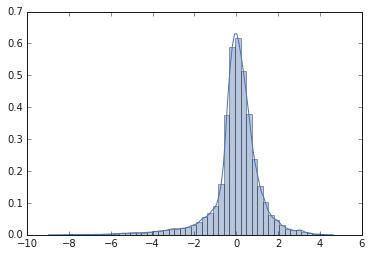

In [138]:
sns.distplot(lm1.resid) ###Residual is normal.

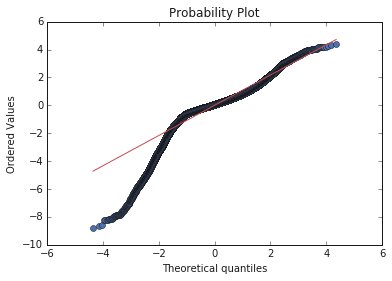

In [139]:
from scipy import stats
import pylab

stats.probplot(lm1.resid, dist="norm", plot=pylab )
pylab.show()

In [0]:
## Testing Dataset

In [0]:
# predicting Weekly_sales on the testing dataset

test_final['Weekly_sales'] = np.exp(lm1.predict(test_final))

In [142]:
test_final.head()

,Date,Date_Week,Date_Month,Date_Year,Date_Day,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type_B,Type_C,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,...,Dept_43,Dept_44,Dept_45,Dept_46,Dept_47,Dept_48,Dept_49,Dept_50,Dept_51,Dept_52,Dept_54,Dept_55,Dept_56,Dept_58,Dept_59,Dept_60,Dept_65,Dept_67,Dept_71,Dept_72,Dept_74,Dept_77,Dept_78,Dept_79,Dept_80,Dept_81,Dept_82,Dept_83,Dept_85,Dept_87,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Weekly_sales
0,2012-11-02,44,11,2012,2,0,151315,55,3,6766,5147,50,3639,2737,223,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34195.565312
1,2012-11-02,44,11,2012,2,0,151315,55,3,6766,5147,50,3639,2737,223,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79468.902045
2,2012-11-02,44,11,2012,2,0,151315,55,3,6766,5147,50,3639,2737,223,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14453.012732
3,2012-11-02,44,11,2012,2,0,151315,55,3,6766,5147,50,3639,2737,223,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51186.391663
4,2012-11-02,44,11,2012,2,0,151315,55,3,6766,5147,50,3639,2737,223,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24304.538773


In [0]:
# Adding date column to the testing dataset

test_final['Store'] = test_conti_vars['Store']
test_final['Dept'] = train_conti_vars['Dept']

In [0]:
submission = pd.concat([test_final.Store, test_final.Dept, test_date_vars.Date, test_final.Weekly_sales], axis = 1)

In [0]:
ID = submission.Store.astype(str) + '_' + submission.Dept.astype(str) + '_' + submission.Date.astype(str)

In [0]:
submission = pd.concat([ID, submission.Weekly_sales], axis = 1)
submission.columns = ['ID', 'Weekly_sales']

In [147]:
# Predicted sales

submission

,ID,Weekly_sales
0,1_1_2012-11-02,34195.565312
1,1_2_2012-11-02,79468.902045
2,1_3_2012-11-02,14453.012732
3,1_4_2012-11-02,51186.391663
4,1_5_2012-11-02,24304.538773
...,...,...
115059,45_71_2013-07-26,10357.863141
115060,45_72_2013-07-26,6869.840623
115061,45_74_2013-07-26,48418.699993
115062,45_77_2013-07-26,7473.983561


In [0]:
# Expoting the submission file
submission.to_csv('Submission_file.csv')